# Concept discovery on dSprites

In [1]:
import sys
sys.path.append('..')
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import simplify_logic
import time
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree, export_text
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import seaborn as sns

import deep_logic as dl
from deep_logic.utils.base import validate_network, set_seed, tree_to_formula
from deep_logic.utils.layer import prune_logic_layers
from deep_logic import logic

from dSprites.dSprites_loader import load_dsprites, concept_filters, get_shape_scale
from dSprites.dSprites_style_I2C import i2c_style

results_dir = 'results_concept/dsprites_h'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

models_dir = 'models_concept/dsprites_h'
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

## Load dSprites data

In [2]:
def get_data(path):
    # Load dataset specified by schema
    dataset_schema = 'small_skip'
    # dataset_schema = 'big_skip'

    # Get filtered concept values
    shape_range, scale_range, rot_range, x_pos_range, y_pos_range = concept_filters(dataset_schema)

    # Define function for filtering out specified concept values only
    def c_filter_fn(concepts):
        in_shape_range = (concepts[1] in shape_range)
        in_scale_range = (concepts[2] in scale_range)
        in_rot_range = (concepts[3] in rot_range)
        in_x_range = (concepts[4] in x_pos_range)
        in_y_range = (concepts[5] in y_pos_range)

        return (in_shape_range and in_scale_range and in_rot_range and in_x_range and in_y_range)

    label_fn = get_shape_scale(shape_range, scale_range)
    
    # Load dataset
    x_train, y_train, x_val, y_val, x_test, y_test, c_train, c_val, c_test, c_names = load_dsprites(path,
                                                                               c_filter_fn=c_filter_fn,
                                                                               label_fn=label_fn,
                                                                               train_test_split_flag=True)


    return x_train, y_train, x_val, y_val, x_test, y_test, c_train, c_val, c_test, c_names

# Load the model, as well as input, label, and concept data
data = get_data(path='./dSprites/data/dsprites.npz')
x_train, y_train, x_val, y_val, x_test, y_test, c_train, c_val, c_test, c_names = data
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.LongTensor(y_val)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
c_train = torch.FloatTensor(c_train)
c_val = torch.FloatTensor(c_val)
c_test = torch.FloatTensor(c_test)
print("Data loaded successfully...")

x_train shape: (20993, 3, 64, 64)
c_train shape: (20993, 50)
y_train shape: (20993, 18)
Number of images in x_train 20993
Number of images in x_val 10341
Number of images in x_test 5530
Data loaded successfully...


In [3]:
y_train2 = y_train[:, [0, 1]]
y_train2[:, 1] = 1 - y_train[:, 1]
y_train2[:, 0].sum() + (1-y_train2[:, 0]).sum()

tensor(20993)

In [4]:
y_val2 = y_val[:, [0, 1]]
y_val2[:, 1] = 1 - y_val[:, 1]
y_test2 = y_test[:, [0, 1]]
y_test2[:, 1] = 1 - y_test[:, 1]

## Generate data loaders

In [5]:
args = {
    'models_dir': './models/dSprites/', 
    'model_style': 'CBM',
    'seed': 0,
    'batch_size': 128,
}

if not os.path.isdir(args['models_dir']):
    os.makedirs(args['models_dir'])

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=False)
val_dataset = TensorDataset(x_val, y_val)
valid_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

# Model
## Define CNN architecture

In [6]:
n_concepts = 50
n_outputs = y_train.size(1)
filter_size = 17

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(8, n_concepts, 3, padding=1)
        self.d1 = dl.nn.DisentangledConcepts(in_features_per_concept=filter_size * filter_size, 
                                             n_concepts=n_concepts, out_features_per_concept=filter_size)
        self.d2 = dl.nn.DisentangledConcepts(in_features_per_concept=filter_size, n_concepts=n_concepts, 
                                             out_features_per_concept=1)
        self.log1 = dl.nn.XLogic(n_concepts, n_outputs, activation='sigmoid')
#         self.fc5 = torch.nn.Linear(n_concepts, n_concepts)
#         self.fc6 = torch.nn.Linear(n_concepts, n_outputs)
        self.log2 = dl.nn.XLogic(n_outputs, n_outputs, top=True, activation='identity')
        # max pooling
        self.pool = torch.nn.MaxPool2d(2, 2, padding=1)
        self.filter_output = None

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        self.filter_output = x
#         print(self.filter_output.shape)
        x = x.view(-1, filter_size * filter_size * n_concepts)
        x = F.leaky_relu(self.d1(x))
        x = self.d2(x)
        x = F.leaky_relu(self.log1(x))
#         x = F.leaky_relu(self.fc5(x))
#         x = F.leaky_relu(self.fc6(x))
        x = self.log2(x)
        return F.log_softmax(x, dim=1)

## Train model

### Whitening Loss function

In [8]:
# the target covariance matrix is diagonal
cov_objective = torch.eye(n_concepts).to(device)

def whitening_loss(model):
    loss = 0
    for module in model.children():
        if isinstance(module, dl.nn.XLogic):
            # compute covariance matrix of activations
            cov = 1 / (n_concepts - 1) * torch.matmul(module.conceptizator.concepts.T, module.conceptizator.concepts)
            loss += torch.norm(cov - cov_objective, p=2)
            break
    return loss, cov

### L1-regularization loss

In [9]:
def l1_loss(model):
    loss = 0
    for module in model.children():
        if isinstance(module, dl.nn.XLogic):
            loss += torch.norm(module.weight, 1) + torch.norm(module.bias, 1)
            break
    return loss

Current Epoch: 1
Training Loss: 2.891003
Validation Loss: 2.888139
Test Accuracy of class "0": 0.0%
Test Accuracy of class "1": 0.0%
Test Accuracy of class "2": 0.0%
Test Accuracy of class "3": 0.0%
Test Accuracy of class "4": 0.0%
Test Accuracy of class "5": 0.0%
Test Accuracy of class "6": 0.0%
Test Accuracy of class "7": 64.86%
Test Accuracy of class "8": 39.13%
Test Accuracy of class "9": 0.0%
Test Accuracy of class "10": 0.0%
Test Accuracy of class "11": 0.0%
Test Accuracy of class "12": 0.0%
Test Accuracy of class "13": 0.0%
Test Accuracy of class "14": 0.0%
Test Accuracy of class "15": 0.0%
Test Accuracy of class "16": 0.0%
Test Accuracy of class "17": 0.0%


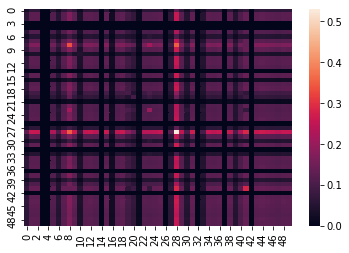

Current Epoch: 2
Training Loss: 2.807915
Validation Loss: 2.707012
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 0.0%
Test Accuracy of class "2": 0.0%
Test Accuracy of class "3": 0.0%
Test Accuracy of class "4": 0.0%
Test Accuracy of class "5": 0.0%
Test Accuracy of class "6": 0.0%
Test Accuracy of class "7": 0.0%
Test Accuracy of class "8": 0.0%
Test Accuracy of class "9": 0.0%
Test Accuracy of class "10": 0.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 0.0%
Test Accuracy of class "14": 0.0%
Test Accuracy of class "15": 0.0%
Test Accuracy of class "16": 0.0%
Test Accuracy of class "17": 0.0%


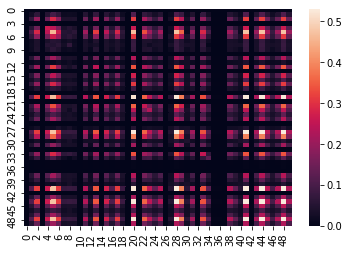

Current Epoch: 3
Training Loss: 1.850535
Validation Loss: 1.023232
Test Accuracy of class "0": 47.83%
Test Accuracy of class "1": 70.0%
Test Accuracy of class "2": 0.0%
Test Accuracy of class "3": 68.52%
Test Accuracy of class "4": 31.25%
Test Accuracy of class "5": 93.48%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 45.95%
Test Accuracy of class "8": 80.43%
Test Accuracy of class "9": 70.73%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 84.21%
Test Accuracy of class "14": 63.27%
Test Accuracy of class "15": 35.56%
Test Accuracy of class "16": 51.02%
Test Accuracy of class "17": 0.0%


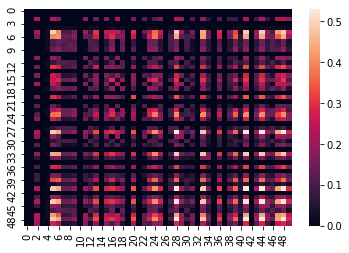

Current Epoch: 4
Training Loss: 0.662076
Validation Loss: 0.498635
Test Accuracy of class "0": 86.96%
Test Accuracy of class "1": 92.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 96.88%
Test Accuracy of class "5": 69.57%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 81.08%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 89.8%
Test Accuracy of class "15": 46.67%
Test Accuracy of class "16": 55.1%
Test Accuracy of class "17": 51.22%


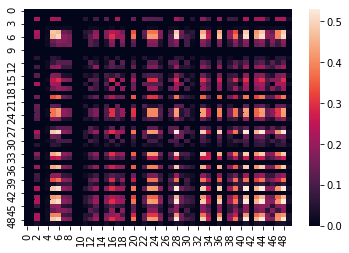

Current Epoch: 5
Training Loss: 0.397952
Validation Loss: 0.353545
Validation loss decreased from inf to 0.353545
Saving New Model
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 59.46%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 55.56%
Test Accuracy of class "16": 73.47%
Test Accuracy of class "17": 70.73%


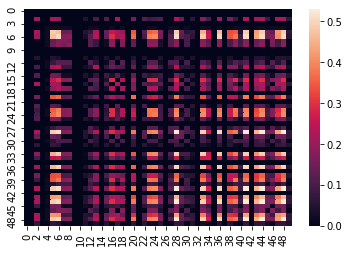

Current Epoch: 6
Training Loss: 0.314785
Validation Loss: 0.342403
Validation loss decreased from 0.353545 to 0.342403
Saving New Model
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 35.14%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 90.24%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 77.78%
Test Accuracy of class "16": 81.63%
Test Accuracy of class "17": 82.93%


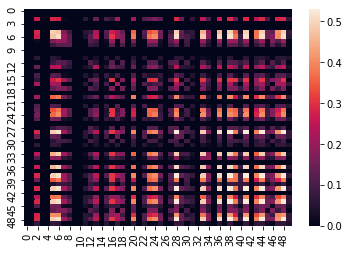

Current Epoch: 7
Training Loss: 0.261097
Validation Loss: 0.292625
Validation loss decreased from 0.342403 to 0.292625
Saving New Model
Test Accuracy of class "0": 89.13%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 96.88%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 64.86%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 81.58%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 71.11%
Test Accuracy of class "16": 79.59%
Test Accuracy of class "17": 90.24%


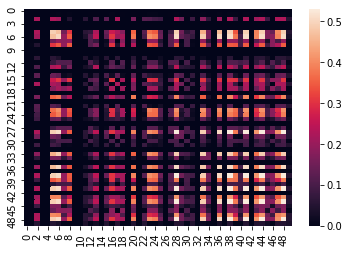

Current Epoch: 8
Training Loss: 0.234927
Validation Loss: 0.278633
Validation loss decreased from 0.292625 to 0.278633
Saving New Model
Test Accuracy of class "0": 86.96%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 96.88%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 76.09%
Test Accuracy of class "7": 83.78%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 92.68%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 89.47%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 80.0%
Test Accuracy of class "16": 77.55%
Test Accuracy of class "17": 92.68%


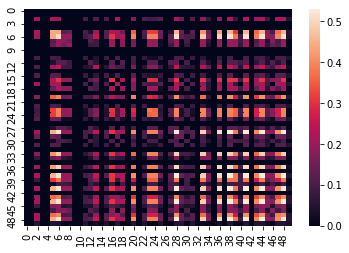

Current Epoch: 9
Training Loss: 0.199562
Validation Loss: 0.319483
Test Accuracy of class "0": 80.43%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 62.16%
Test Accuracy of class "8": 82.61%
Test Accuracy of class "9": 92.68%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 89.47%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 73.33%
Test Accuracy of class "16": 67.35%
Test Accuracy of class "17": 58.54%


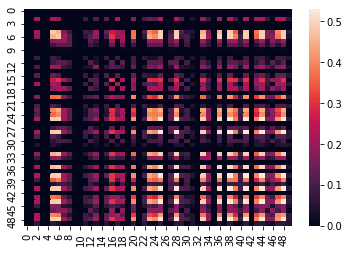

Current Epoch: 10
Training Loss: 0.188942
Validation Loss: 0.304882
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 43.24%
Test Accuracy of class "8": 67.39%
Test Accuracy of class "9": 92.68%
Test Accuracy of class "10": 92.68%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 73.33%
Test Accuracy of class "16": 63.27%
Test Accuracy of class "17": 82.93%


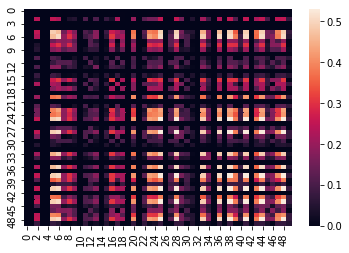

Current Epoch: 11
Training Loss: 0.157759
Validation Loss: 0.198779
Validation loss decreased from 0.278633 to 0.198779
Saving New Model
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 70.27%
Test Accuracy of class "8": 78.26%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 86.67%
Test Accuracy of class "16": 83.67%
Test Accuracy of class "17": 92.68%


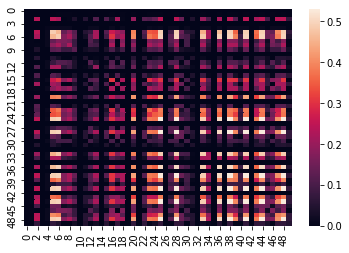

Current Epoch: 12
Training Loss: 0.134986
Validation Loss: 0.183991
Validation loss decreased from 0.198779 to 0.183991
Saving New Model
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 92.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 89.13%
Test Accuracy of class "7": 67.57%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 71.43%
Test Accuracy of class "17": 85.37%


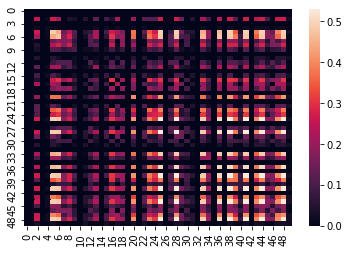

Current Epoch: 13
Training Loss: 0.120481
Validation Loss: 0.180786
Validation loss decreased from 0.183991 to 0.180786
Saving New Model
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 90.62%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 81.58%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 91.11%
Test Accuracy of class "16": 75.51%
Test Accuracy of class "17": 75.61%


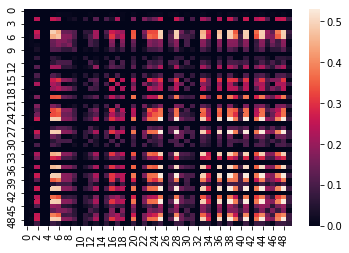

Current Epoch: 14
Training Loss: 0.130879
Validation Loss: 0.147648
Validation loss decreased from 0.180786 to 0.147648
Saving New Model
Test Accuracy of class "0": 89.13%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 72.97%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 91.84%
Test Accuracy of class "17": 95.12%


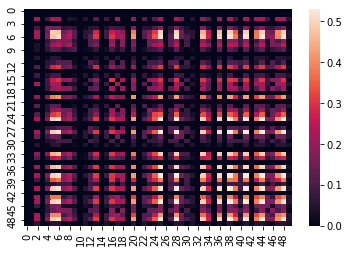

Current Epoch: 15
Training Loss: 0.099487
Validation Loss: 0.120811
Validation loss decreased from 0.147648 to 0.120811
Saving New Model
Test Accuracy of class "0": 100.0%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 86.49%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 86.67%
Test Accuracy of class "16": 91.84%
Test Accuracy of class "17": 97.56%


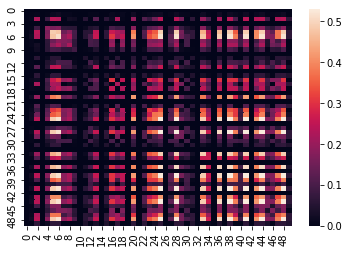

Current Epoch: 16
Training Loss: 0.079554
Validation Loss: 0.145911
Test Accuracy of class "0": 76.09%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 96.88%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 72.97%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 91.11%
Test Accuracy of class "16": 87.76%
Test Accuracy of class "17": 97.56%


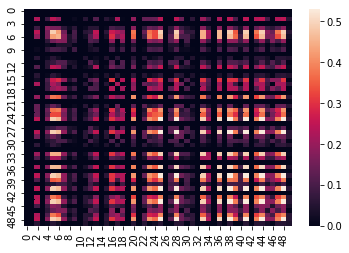

Current Epoch: 17
Training Loss: 0.087971
Validation Loss: 0.11746
Validation loss decreased from 0.120811 to 0.11746
Saving New Model
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 86.49%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 87.76%
Test Accuracy of class "17": 92.68%


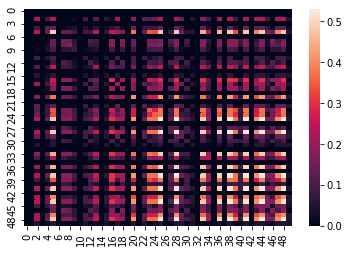

Current Epoch: 18
Training Loss: 0.069167
Validation Loss: 0.102478
Validation loss decreased from 0.11746 to 0.102478
Saving New Model
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 75.68%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


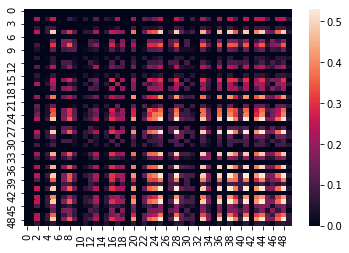

Current Epoch: 19
Training Loss: 0.068464
Validation Loss: 0.12615
Test Accuracy of class "0": 100.0%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 70.27%
Test Accuracy of class "8": 78.26%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 95.12%


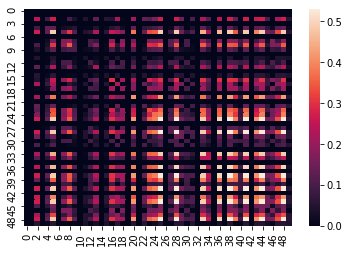

Current Epoch: 20
Training Loss: 0.058911
Validation Loss: 0.154426
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 59.46%
Test Accuracy of class "8": 69.57%
Test Accuracy of class "9": 92.68%
Test Accuracy of class "10": 92.68%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 100.0%


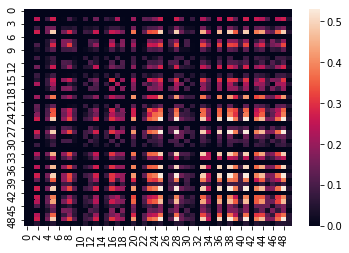

Current Epoch: 21
Training Loss: 0.072868
Validation Loss: 0.123679
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 70.27%
Test Accuracy of class "8": 86.96%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 91.84%
Test Accuracy of class "17": 95.12%


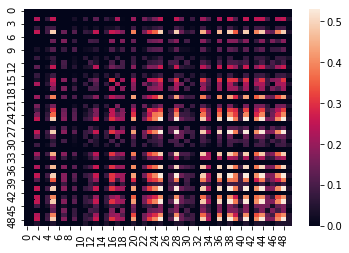

Current Epoch: 22
Training Loss: 0.076986
Validation Loss: 0.245968
Test Accuracy of class "0": 100.0%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 89.13%
Test Accuracy of class "9": 68.29%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 93.88%
Test Accuracy of class "15": 80.0%
Test Accuracy of class "16": 42.86%
Test Accuracy of class "17": 100.0%


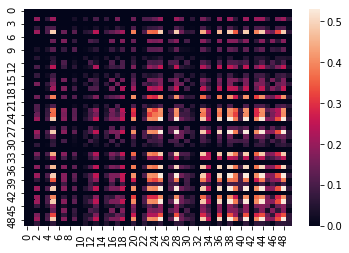

Current Epoch: 23
Training Loss: 0.076803
Validation Loss: 0.139024
Test Accuracy of class "0": 89.13%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 91.3%
Test Accuracy of class "7": 72.97%
Test Accuracy of class "8": 84.78%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 92.68%


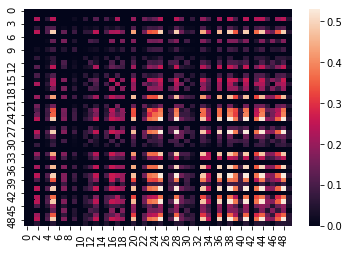

Current Epoch: 24
Training Loss: 0.052557
Validation Loss: 0.096079
Validation loss decreased from 0.102478 to 0.096079
Saving New Model
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 81.08%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 91.11%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 95.12%


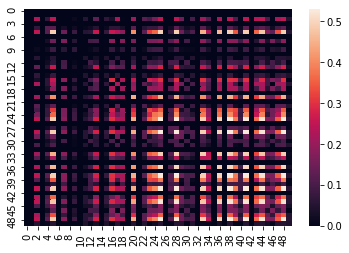

Current Epoch: 25
Training Loss: 0.040175
Validation Loss: 0.088826
Validation loss decreased from 0.096079 to 0.088826
Saving New Model
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 91.11%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 97.56%


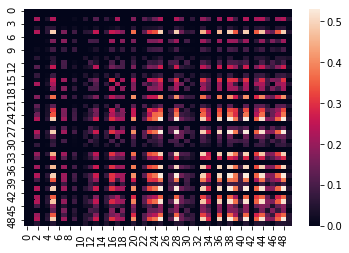

Current Epoch: 26
Training Loss: 0.038197
Validation Loss: 0.12881
Test Accuracy of class "0": 84.78%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 72.97%
Test Accuracy of class "8": 89.13%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 87.76%
Test Accuracy of class "17": 97.56%


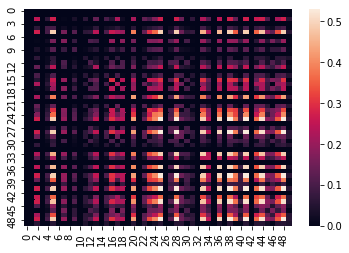

Current Epoch: 27
Training Loss: 0.037233
Validation Loss: 0.127449
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 78.26%
Test Accuracy of class "7": 72.97%
Test Accuracy of class "8": 84.78%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


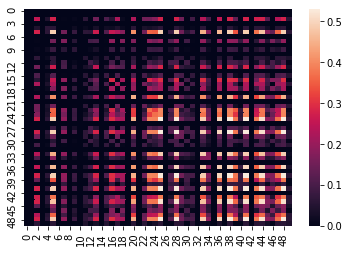

Current Epoch: 28
Training Loss: 0.085192
Validation Loss: 0.287394
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 51.35%
Test Accuracy of class "8": 60.87%
Test Accuracy of class "9": 85.37%
Test Accuracy of class "10": 85.37%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 94.44%
Test Accuracy of class "13": 84.21%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 86.67%
Test Accuracy of class "16": 89.8%
Test Accuracy of class "17": 95.12%


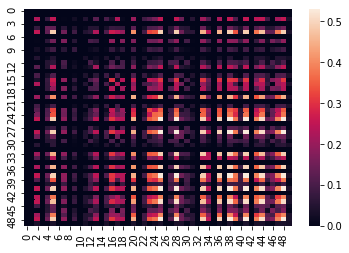

Current Epoch: 29
Training Loss: 0.070334
Validation Loss: 0.113005
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 75.68%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 92.68%


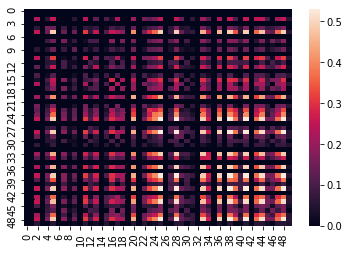

Current Epoch: 30
Training Loss: 0.046743
Validation Loss: 0.123143
Test Accuracy of class "0": 89.13%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 72.97%
Test Accuracy of class "8": 89.13%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 91.11%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 100.0%


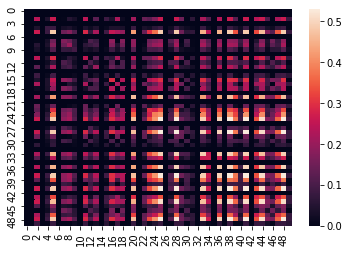

Current Epoch: 31
Training Loss: 0.033479
Validation Loss: 0.074184
Validation loss decreased from 0.088826 to 0.074184
Saving New Model
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 91.84%
Test Accuracy of class "17": 97.56%


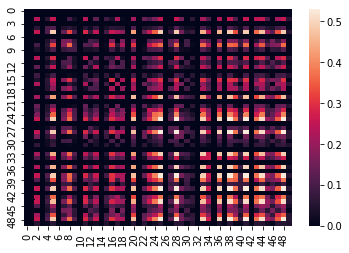

Current Epoch: 32
Training Loss: 0.032311
Validation Loss: 0.08337
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 83.78%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


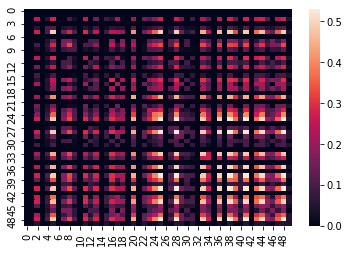

Current Epoch: 33
Training Loss: 0.029179
Validation Loss: 0.077274
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


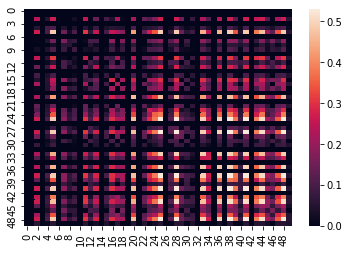

Current Epoch: 34
Training Loss: 0.03538
Validation Loss: 0.109342
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 78.38%
Test Accuracy of class "8": 84.78%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 100.0%


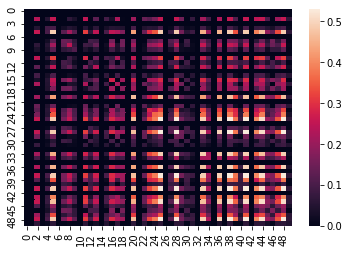

Current Epoch: 35
Training Loss: 0.022663
Validation Loss: 0.090921
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 83.78%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 88.89%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 100.0%


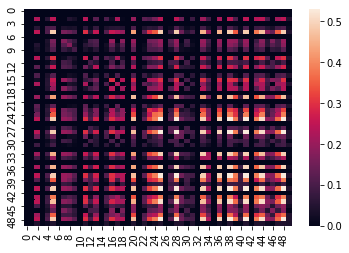

Current Epoch: 36
Training Loss: 0.071992
Validation Loss: 0.34587
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 21.74%
Test Accuracy of class "6": 91.3%
Test Accuracy of class "7": 78.38%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 92.68%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 98.08%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 86.67%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 95.12%


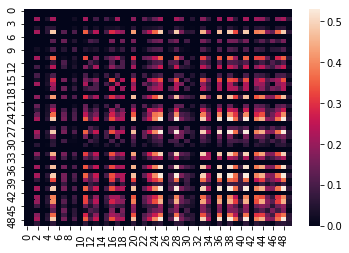

Current Epoch: 37
Training Loss: 0.085599
Validation Loss: 0.124132
Test Accuracy of class "0": 84.78%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 81.08%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 71.05%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 91.11%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 87.8%


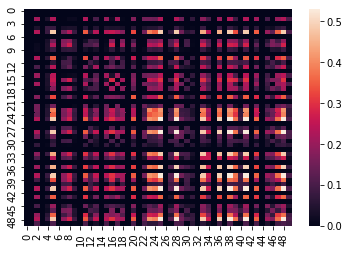

Current Epoch: 38
Training Loss: 0.060467
Validation Loss: 0.129457
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 78.26%
Test Accuracy of class "7": 86.49%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 82.22%
Test Accuracy of class "16": 91.84%
Test Accuracy of class "17": 95.12%


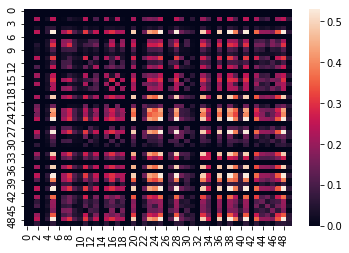

Current Epoch: 39
Training Loss: 0.051691
Validation Loss: 0.083287
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 86.49%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


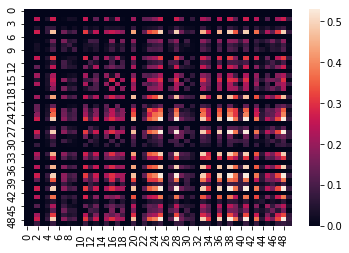

Current Epoch: 40
Training Loss: 0.035914
Validation Loss: 0.111478
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 72.97%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


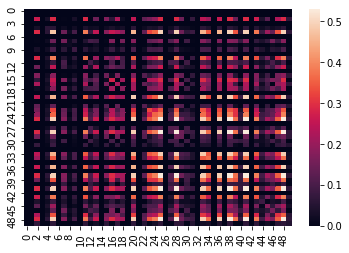

Current Epoch: 41
Training Loss: 0.030746
Validation Loss: 0.103085
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 83.78%
Test Accuracy of class "8": 89.13%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 100.0%


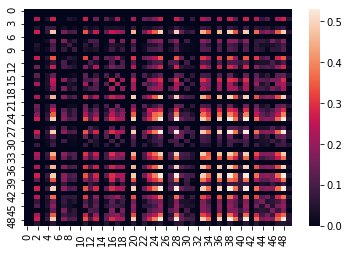

Current Epoch: 42
Training Loss: 0.026152
Validation Loss: 0.075029
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 100.0%


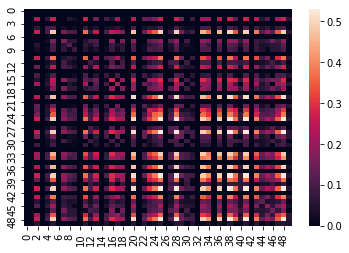

Current Epoch: 43
Training Loss: 0.020486
Validation Loss: 0.11459
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 91.3%
Test Accuracy of class "7": 78.38%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


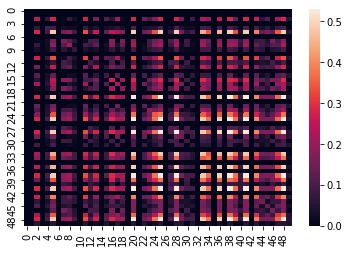

Current Epoch: 44
Training Loss: 0.017306
Validation Loss: 0.084809
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 89.13%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 98.08%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 95.12%


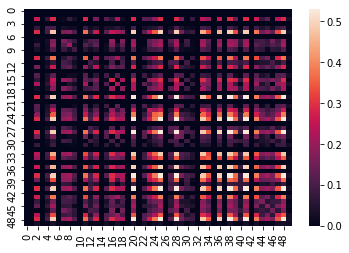

Current Epoch: 45
Training Loss: 0.01947
Validation Loss: 0.363174
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 6.52%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 100.0%


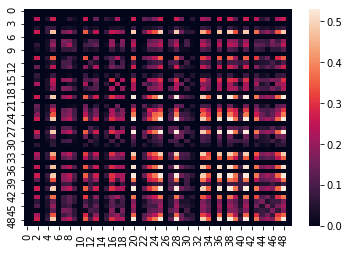

Current Epoch: 46
Training Loss: 0.125248
Validation Loss: 0.110967
Test Accuracy of class "0": 89.13%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 96.88%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 95.12%


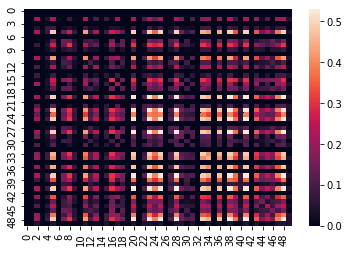

Current Epoch: 47
Training Loss: 0.05017
Validation Loss: 0.09163
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 86.67%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 100.0%


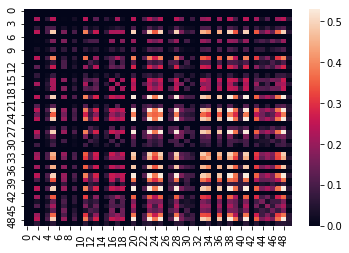

Current Epoch: 48
Training Loss: 0.034424
Validation Loss: 0.097949
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 91.3%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 97.56%


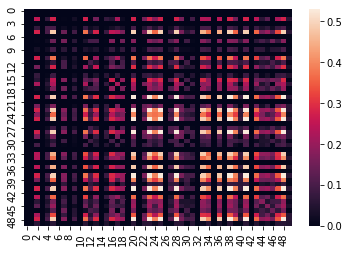

Current Epoch: 49
Training Loss: 0.024192
Validation Loss: 0.079711
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 100.0%


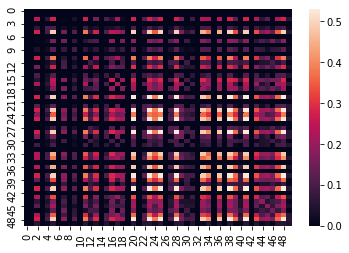

Current Epoch: 50
Training Loss: 0.04416
Validation Loss: 0.138112
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 75.68%
Test Accuracy of class "8": 82.61%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 100.0%


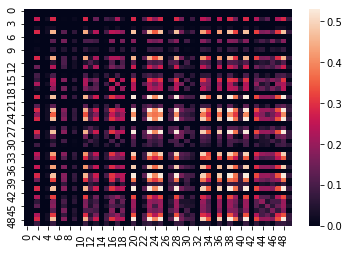

Current Epoch: 51
Training Loss: 0.058262
Validation Loss: 0.188438
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 87.5%
Test Accuracy of class "2": 88.57%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 96.88%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 89.13%
Test Accuracy of class "7": 67.57%
Test Accuracy of class "8": 82.61%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 91.84%
Test Accuracy of class "17": 92.68%


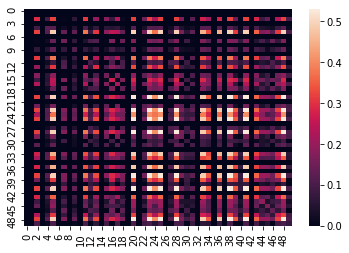

Current Epoch: 52
Training Loss: 0.034672
Validation Loss: 0.075336
Test Accuracy of class "0": 100.0%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 100.0%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 97.56%


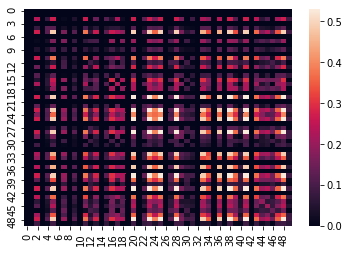

Current Epoch: 53
Training Loss: 0.016769
Validation Loss: 0.070438
Validation loss decreased from 0.074184 to 0.070438
Saving New Model
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 100.0%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


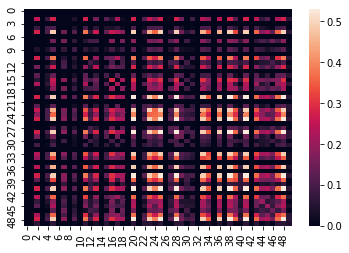

Current Epoch: 54
Training Loss: 0.014722
Validation Loss: 0.069617
Validation loss decreased from 0.070438 to 0.069617
Saving New Model
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


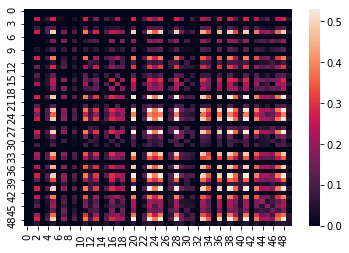

Current Epoch: 55
Training Loss: 0.011136
Validation Loss: 0.071105
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 100.0%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 91.11%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


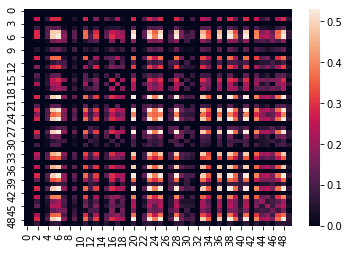

Current Epoch: 56
Training Loss: 0.01102
Validation Loss: 0.090034
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 86.49%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 97.56%


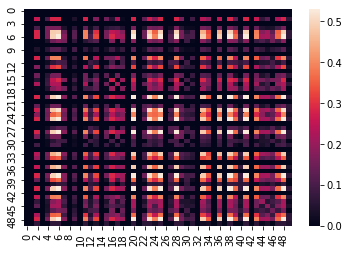

Current Epoch: 57
Training Loss: 0.013611
Validation Loss: 0.085302
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 78.38%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 95.12%


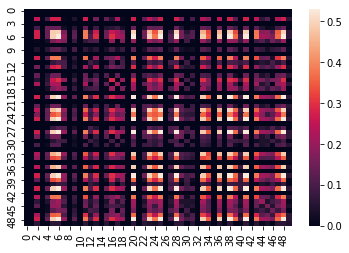

Current Epoch: 58
Training Loss: 0.031194
Validation Loss: 0.379497
Test Accuracy of class "0": 69.57%
Test Accuracy of class "1": 67.5%
Test Accuracy of class "2": 60.0%
Test Accuracy of class "3": 81.48%
Test Accuracy of class "4": 93.75%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 78.38%
Test Accuracy of class "8": 84.78%
Test Accuracy of class "9": 92.68%
Test Accuracy of class "10": 95.12%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 92.11%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 97.56%


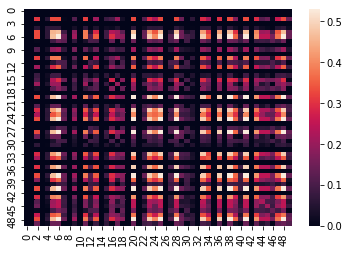

Current Epoch: 59
Training Loss: 0.131007
Validation Loss: 0.317453
Test Accuracy of class "0": 58.7%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 62.96%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 75.68%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 53.66%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 93.88%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 87.8%


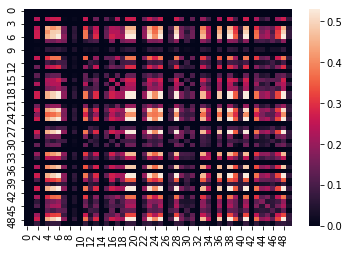

Current Epoch: 60
Training Loss: 0.06068
Validation Loss: 0.131941
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 78.38%
Test Accuracy of class "8": 84.78%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 87.8%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 100.0%


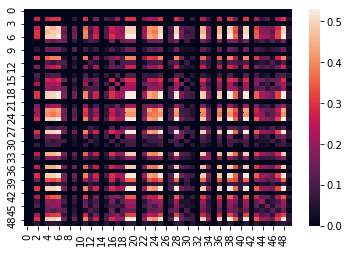

Current Epoch: 61
Training Loss: 0.021498
Validation Loss: 0.079798
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 100.0%


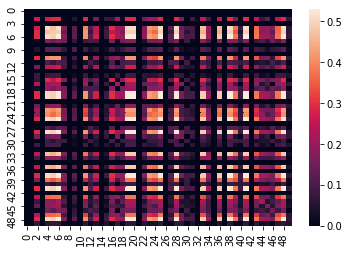

Current Epoch: 62
Training Loss: 0.013478
Validation Loss: 0.086306
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 81.08%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


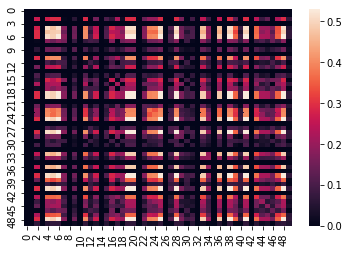

Current Epoch: 63
Training Loss: 0.012529
Validation Loss: 0.071006
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


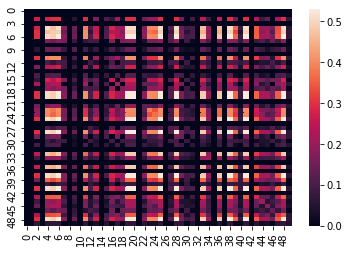

Current Epoch: 64
Training Loss: 0.012308
Validation Loss: 0.087794
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 100.0%


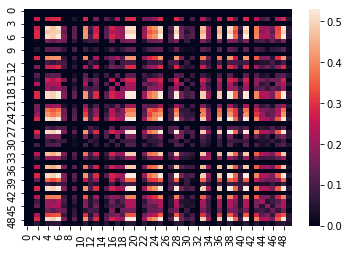

Current Epoch: 65
Training Loss: 0.010579
Validation Loss: 0.062653
Validation loss decreased from 0.069617 to 0.062653
Saving New Model
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


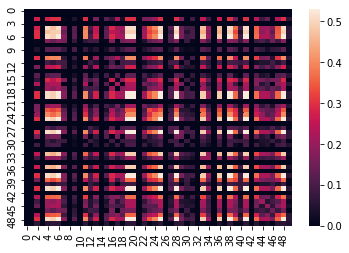

Current Epoch: 66
Training Loss: 0.009291
Validation Loss: 0.05798
Validation loss decreased from 0.062653 to 0.05798
Saving New Model
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


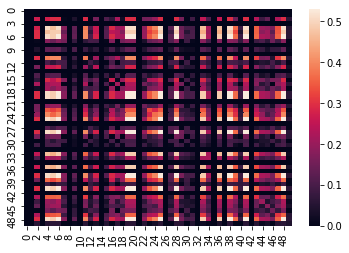

Current Epoch: 67
Training Loss: 0.012181
Validation Loss: 0.068546
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


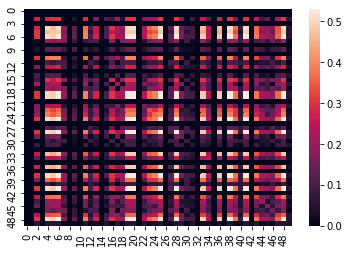

Current Epoch: 68
Training Loss: 0.036717
Validation Loss: 0.473825
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 95.0%
Test Accuracy of class "2": 48.57%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 86.49%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 39.02%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 91.84%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 24.49%
Test Accuracy of class "17": 95.12%


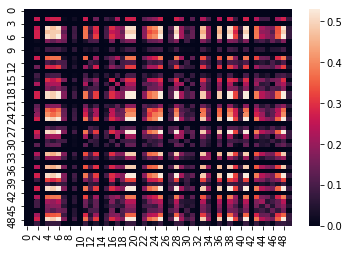

Current Epoch: 69
Training Loss: 0.147762
Validation Loss: 0.141266
Test Accuracy of class "0": 97.83%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 67.57%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 92.11%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 97.56%


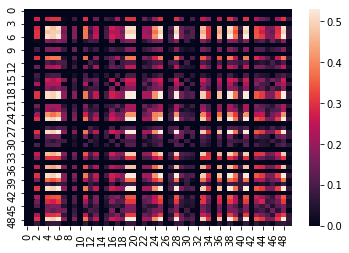

Current Epoch: 70
Training Loss: 0.023875
Validation Loss: 0.073826
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 94.74%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 100.0%


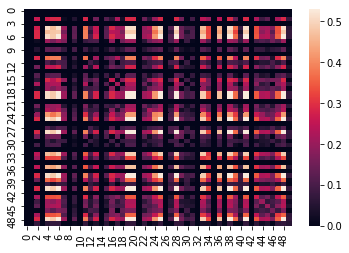

Current Epoch: 71
Training Loss: 0.011702
Validation Loss: 0.058419
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


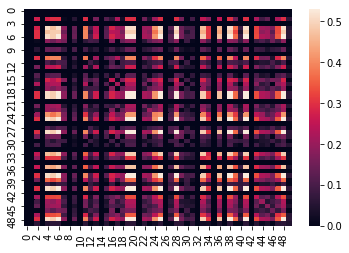

Current Epoch: 72
Training Loss: 0.009044
Validation Loss: 0.059801
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 95.12%


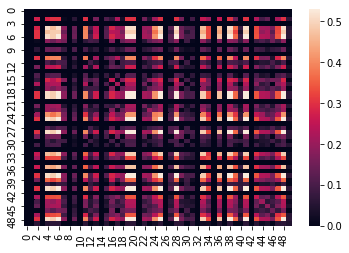

Current Epoch: 73
Training Loss: 0.008848
Validation Loss: 0.057034
Validation loss decreased from 0.05798 to 0.057034
Saving New Model
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


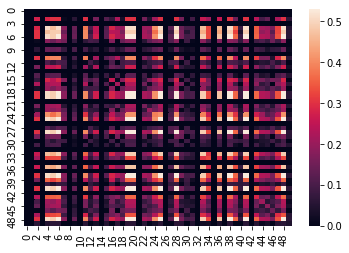

Current Epoch: 74
Training Loss: 0.007651
Validation Loss: 0.057538
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


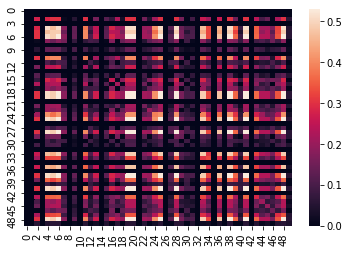

Current Epoch: 75
Training Loss: 0.00735
Validation Loss: 0.060298
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 95.12%


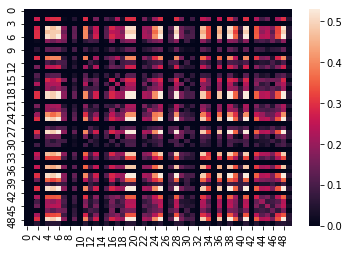

Current Epoch: 76
Training Loss: 0.006809
Validation Loss: 0.054852
Validation loss decreased from 0.057034 to 0.054852
Saving New Model
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 95.12%


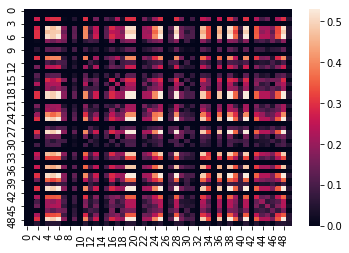

Current Epoch: 77
Training Loss: 0.035161
Validation Loss: 0.824947
Test Accuracy of class "0": 84.78%
Test Accuracy of class "1": 32.5%
Test Accuracy of class "2": 88.57%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 84.38%
Test Accuracy of class "5": 19.57%
Test Accuracy of class "6": 28.26%
Test Accuracy of class "7": 78.38%
Test Accuracy of class "8": 82.61%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 50.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 78.95%
Test Accuracy of class "14": 61.22%
Test Accuracy of class "15": 42.22%
Test Accuracy of class "16": 67.35%
Test Accuracy of class "17": 82.93%


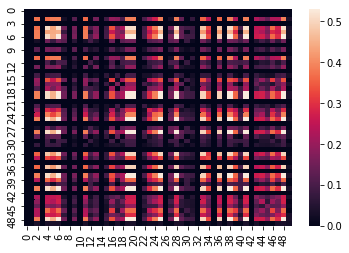

Current Epoch: 78
Training Loss: 0.449223
Validation Loss: 0.14963
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 91.84%
Test Accuracy of class "17": 95.12%


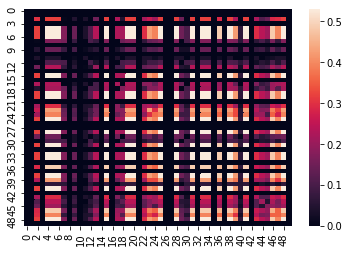

Current Epoch: 79
Training Loss: 0.081334
Validation Loss: 0.120937
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 83.78%
Test Accuracy of class "8": 91.3%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


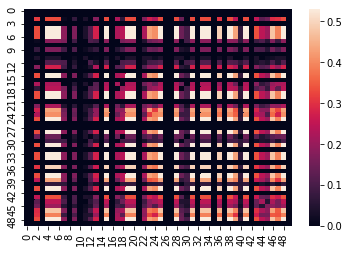

Current Epoch: 80
Training Loss: 0.049502
Validation Loss: 0.081845
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


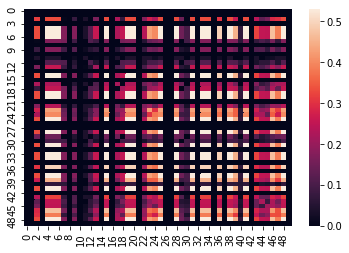

Current Epoch: 81
Training Loss: 0.037164
Validation Loss: 0.086171
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 100.0%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


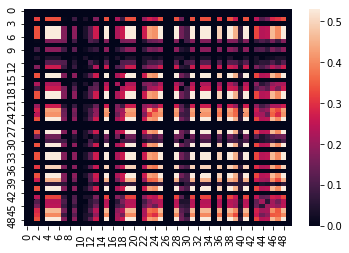

Current Epoch: 82
Training Loss: 0.033305
Validation Loss: 0.100153
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 100.0%
Test Accuracy of class "8": 100.0%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 96.3%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 89.8%
Test Accuracy of class "17": 95.12%


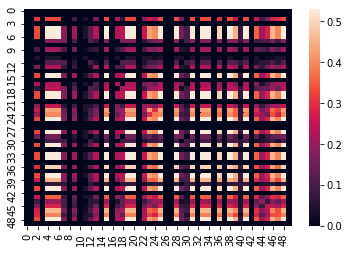

Current Epoch: 83
Training Loss: 0.029266
Validation Loss: 0.08189
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


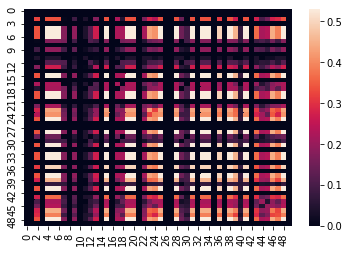

Current Epoch: 84
Training Loss: 0.02342
Validation Loss: 0.117733
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 82.61%
Test Accuracy of class "7": 81.08%
Test Accuracy of class "8": 86.96%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 97.56%


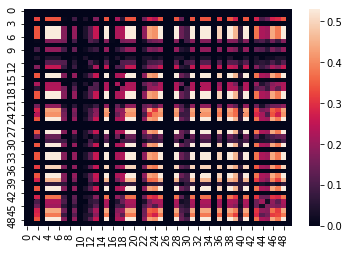

Current Epoch: 85
Training Loss: 0.020774
Validation Loss: 0.079974
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


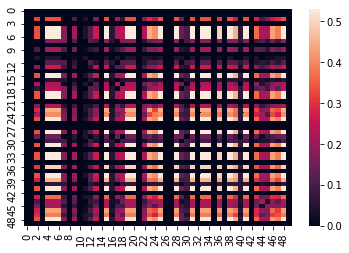

Current Epoch: 86
Training Loss: 0.01747
Validation Loss: 0.079109
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


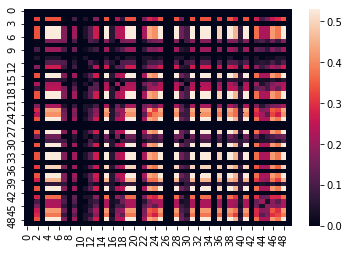

Current Epoch: 87
Training Loss: 0.016073
Validation Loss: 0.071585
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 97.56%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


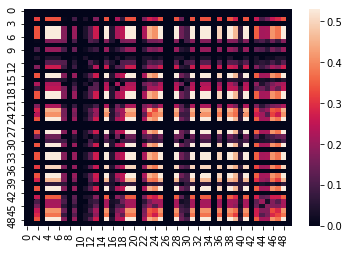

Current Epoch: 88
Training Loss: 0.016913
Validation Loss: 0.079467
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 91.3%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 97.56%


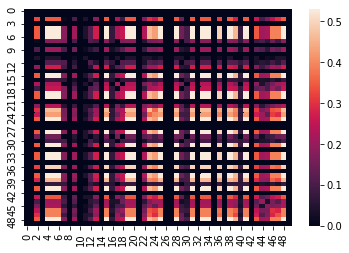

Current Epoch: 89
Training Loss: 0.098001
Validation Loss: 0.246666
Test Accuracy of class "0": 82.61%
Test Accuracy of class "1": 85.0%
Test Accuracy of class "2": 94.29%
Test Accuracy of class "3": 85.19%
Test Accuracy of class "4": 96.88%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 86.96%
Test Accuracy of class "7": 86.49%
Test Accuracy of class "8": 89.13%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 92.68%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 93.88%
Test Accuracy of class "15": 100.0%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 92.68%


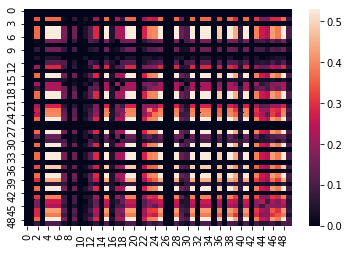

Current Epoch: 90
Training Loss: 0.06843
Validation Loss: 0.108473
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 83.78%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 92.11%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 92.68%


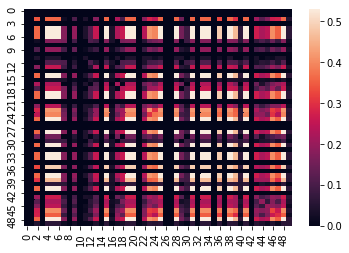

Current Epoch: 91
Training Loss: 0.030218
Validation Loss: 0.070767
Test Accuracy of class "0": 95.65%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 95.65%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


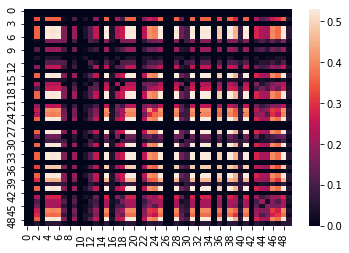

Current Epoch: 92
Training Loss: 0.016513
Validation Loss: 0.063117
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 97.56%


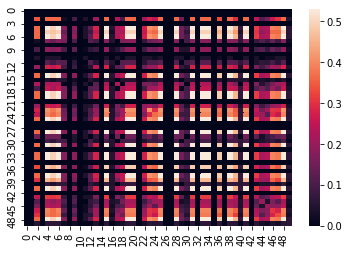

Current Epoch: 93
Training Loss: 0.014112
Validation Loss: 0.072268
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 100.0%
Test Accuracy of class "17": 97.56%


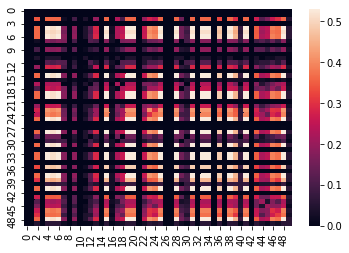

Current Epoch: 94
Training Loss: 0.015898
Validation Loss: 0.065209
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 94.59%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


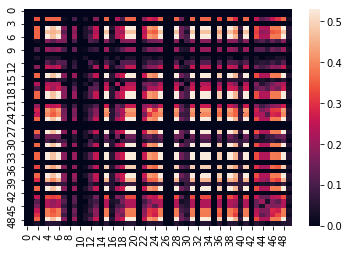

Current Epoch: 95
Training Loss: 0.013029
Validation Loss: 0.077431
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 97.83%
Test Accuracy of class "7": 89.19%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 95.12%


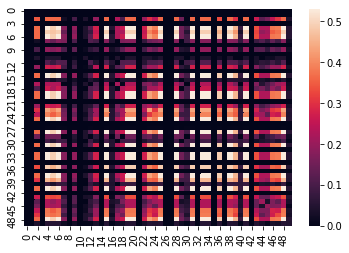

Current Epoch: 96
Training Loss: 0.019432
Validation Loss: 0.066489
Test Accuracy of class "0": 91.3%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 93.48%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 100.0%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 93.88%
Test Accuracy of class "17": 97.56%


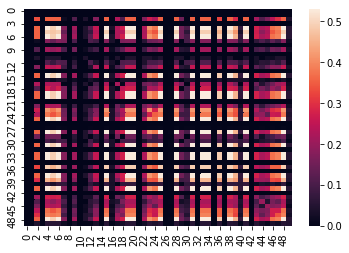

Current Epoch: 97
Training Loss: 0.014851
Validation Loss: 0.110069
Test Accuracy of class "0": 89.13%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 94.29%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 100.0%
Test Accuracy of class "9": 100.0%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 98.15%
Test Accuracy of class "13": 84.21%
Test Accuracy of class "14": 97.96%
Test Accuracy of class "15": 93.33%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 90.24%


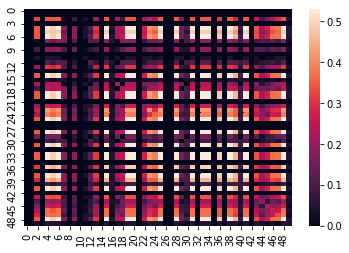

Current Epoch: 98
Training Loss: 0.034833
Validation Loss: 0.084046
Test Accuracy of class "0": 84.78%
Test Accuracy of class "1": 97.5%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 97.3%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 95.12%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 97.56%


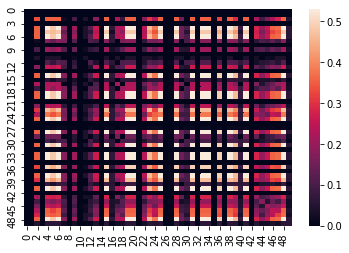

Current Epoch: 99
Training Loss: 0.080951
Validation Loss: 0.164201
Test Accuracy of class "0": 89.13%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 97.14%
Test Accuracy of class "3": 98.15%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 100.0%
Test Accuracy of class "6": 93.48%
Test Accuracy of class "7": 64.86%
Test Accuracy of class "8": 95.65%
Test Accuracy of class "9": 87.8%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 94.44%
Test Accuracy of class "13": 84.21%
Test Accuracy of class "14": 95.92%
Test Accuracy of class "15": 95.56%
Test Accuracy of class "16": 97.96%
Test Accuracy of class "17": 97.56%


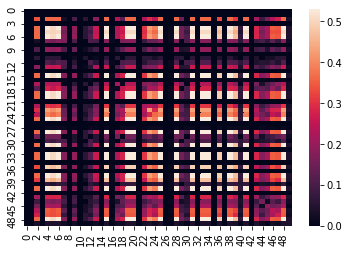

Current Epoch: 100
Training Loss: 0.043504
Validation Loss: 0.083029
Test Accuracy of class "0": 93.48%
Test Accuracy of class "1": 100.0%
Test Accuracy of class "2": 100.0%
Test Accuracy of class "3": 100.0%
Test Accuracy of class "4": 100.0%
Test Accuracy of class "5": 89.13%
Test Accuracy of class "6": 100.0%
Test Accuracy of class "7": 91.89%
Test Accuracy of class "8": 97.83%
Test Accuracy of class "9": 97.56%
Test Accuracy of class "10": 100.0%
Test Accuracy of class "11": 100.0%
Test Accuracy of class "12": 100.0%
Test Accuracy of class "13": 97.37%
Test Accuracy of class "14": 100.0%
Test Accuracy of class "15": 97.78%
Test Accuracy of class "16": 95.92%
Test Accuracy of class "17": 92.68%


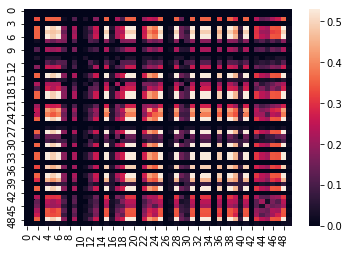

<All keys matched successfully>

In [10]:
model = Net()
model.cuda()

# if os.path.isfile('./models_ll/dsprites_h/trained_model_h3.pt'):
#     # load trained model
#     model.load_state_dict(torch.load('./models_ll/dsprites_h/trained_model_h3.pt'))

# else:
epochs = 100
set_seed(0)
need_pruning = True

# tracks validation loss change after each epoch
minimum_validation_loss = np.inf

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
for epoch in range(1, epochs + 1):

    train_loss = 0
    valid_loss = 0

    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda()
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # loss in batch
#         if epoch < 5:
#             loss = whitening_loss(model)[0] #+ l1_loss(model)
#         else:
        reg = 0.00001
        loss = criterion(output, target.argmax(dim=1)) + reg * whitening_loss(model)[0] #+ reg * l1_loss(model)

        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target.argmax(dim=1))
        # update validation loss
        valid_loss += loss.item() * data.size(0)

    # average loss calculations
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}\nValidation Loss: {round(valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if valid_loss <= minimum_validation_loss and epoch > 4:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
        torch.save(model.state_dict(), './models_ll/dsprites_h/trained_model_h3.pt')
        minimum_validation_loss = valid_loss
        print('Saving New Model')

    # tracking test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(n_outputs))
    class_total = list(0. for i in range(n_outputs))

    # test steps
    model.eval()
    for batch_index, (data, target) in enumerate(test_loader):
        # moves tensors to GPU
        data, target = data.cuda(), target.cuda() % 2
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target.argmax(dim=1))

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.argmax(dim=1).data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
            correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(n_outputs):
            label = target.argmax(dim=1).data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    for i in range(n_outputs):
        print(f'Test Accuracy of class "{i}": {round(100 * class_correct[i] / class_total[i], 2)}%')

    cov_np = whitening_loss(model)[1].cpu().detach().numpy()
    plt.figure()
    sns.heatmap(cov_np)
    plt.show()

model.load_state_dict(torch.load('./models_ll/dsprites_h/trained_model_h3.pt'))

In [11]:
target.shape

torch.Size([26, 18])

In [12]:
output.shape

torch.Size([26, 18])

# Concepts' visualization

### Feed the network with validation data

In [13]:
model.eval()
x_subset, y_subset, pred_subset = [], [], []
for i, (x_subset_i, y_subset_i) in enumerate(iter(train_loader)):
    x_subset.append(x_subset_i)
    y_subset.append(y_subset_i)
    pred_subset.append(model.cpu()(x_subset_i))
    if i > 5: break

x_subset = torch.cat(x_subset)
y_subset = torch.cat(y_subset)
pred_subset = torch.cat(pred_subset)

model.cpu()(x_subset)
symbols = model.log1.conceptizator.concepts

### Covariance matrix in the concept layer

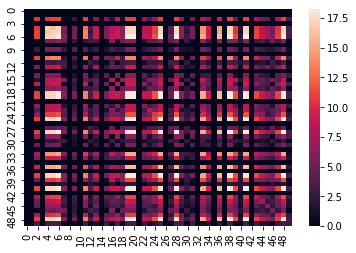

In [14]:
cov_objective = cov_objective.cpu()
cov_np = whitening_loss(model.cpu())[1].cpu().detach().numpy()

plt.figure()
sns.heatmap(cov_np)
plt.show()

## Visualize concepts 

### Concept filters

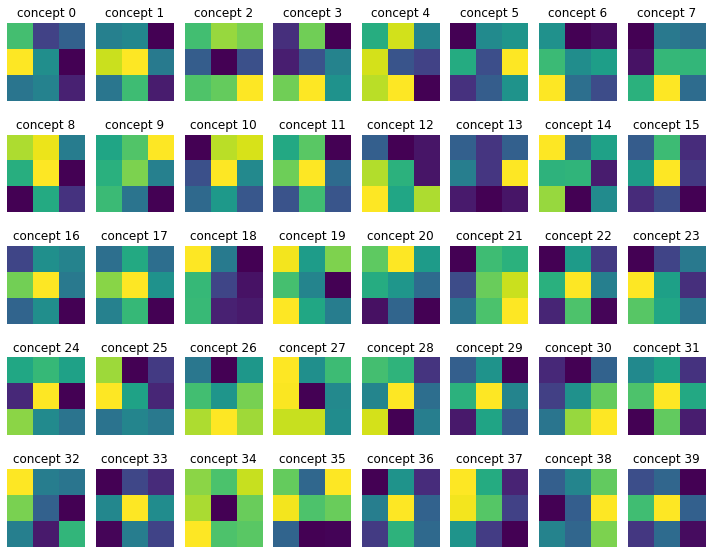

In [15]:
plt.figure(figsize=[10, 8])
max_c = 8
max_r = 5
for i in range(model.conv2.weight.size(0)):
    plt.subplot(max_r, max_c, i + 1)
    plt.title(f'concept {i}')
    plt.imshow(model.conv2.weight[i].sum(dim=0).detach().numpy())
    plt.axis('off')
    if i >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_filters.png')
plt.show()

### Concept embeddings

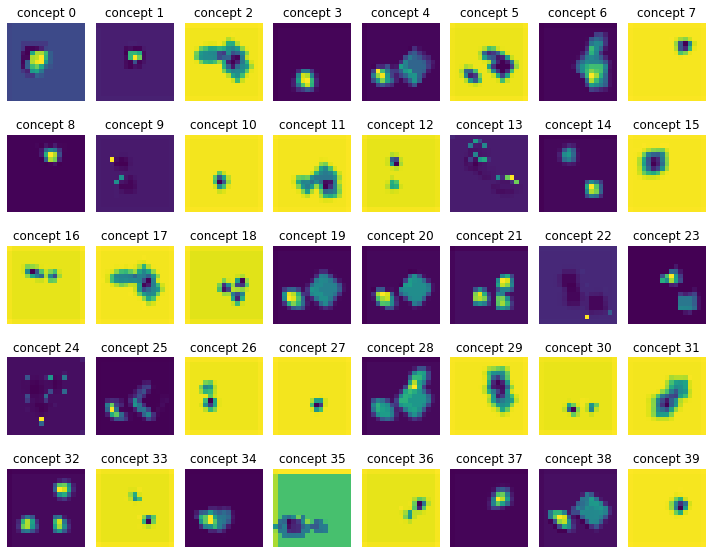

In [16]:
plt.figure(figsize=[10, 8])
max_c = 8
max_r = 5
for q, c in enumerate(torch.topk(symbols.abs(), k=3, dim=0)[1].T):
    plt.subplot(max_r, max_c, q + 1)
    plt.title(f'concept {q}')
    plt.imshow((model.filter_output[c, q] + 1).sum(dim=0).cpu().detach().numpy())
    plt.axis('off')
    if q >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_filters_output.png')
plt.show()

### Input images associated with concepts

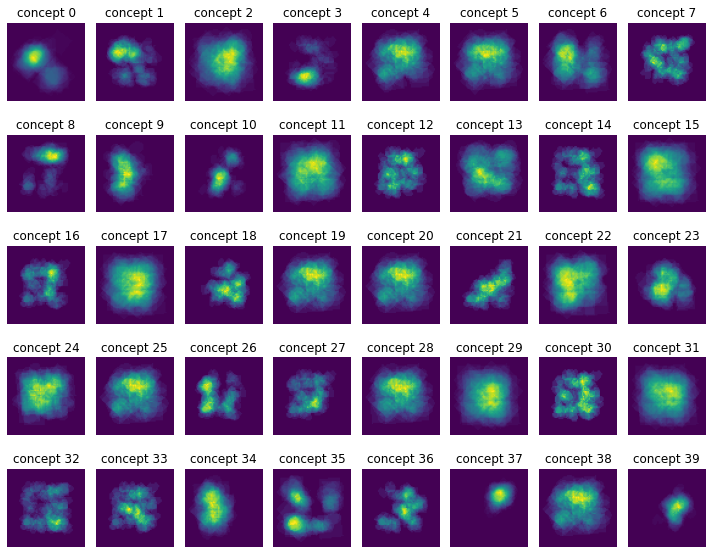

In [17]:
plt.figure(figsize=[10, 8])
max_c = 8
max_r = 5
for q, c in enumerate(torch.topk(symbols.abs(), k=100, dim=0)[1].T):
    plt.subplot(max_r, max_c, q + 1)
    plt.title(f'concept {q}')
    #     plt.imshow((x_subset[c, 0]+1).sum(dim=0).exp())
    plt.imshow((x_subset[c, 0] + 1).sum(dim=0))
    #     plt.figure(figsize=[10,2])
    #     for j, i in enumerate(c):
    #         plt.subplot(1, len(c), j+1)
    #         plt.imshow(x_subset[i, 0])
    plt.axis('off')
    if q >= (max_c * max_r - 1): break
plt.tight_layout()
plt.savefig('mnist_concepts.png')
plt.show()

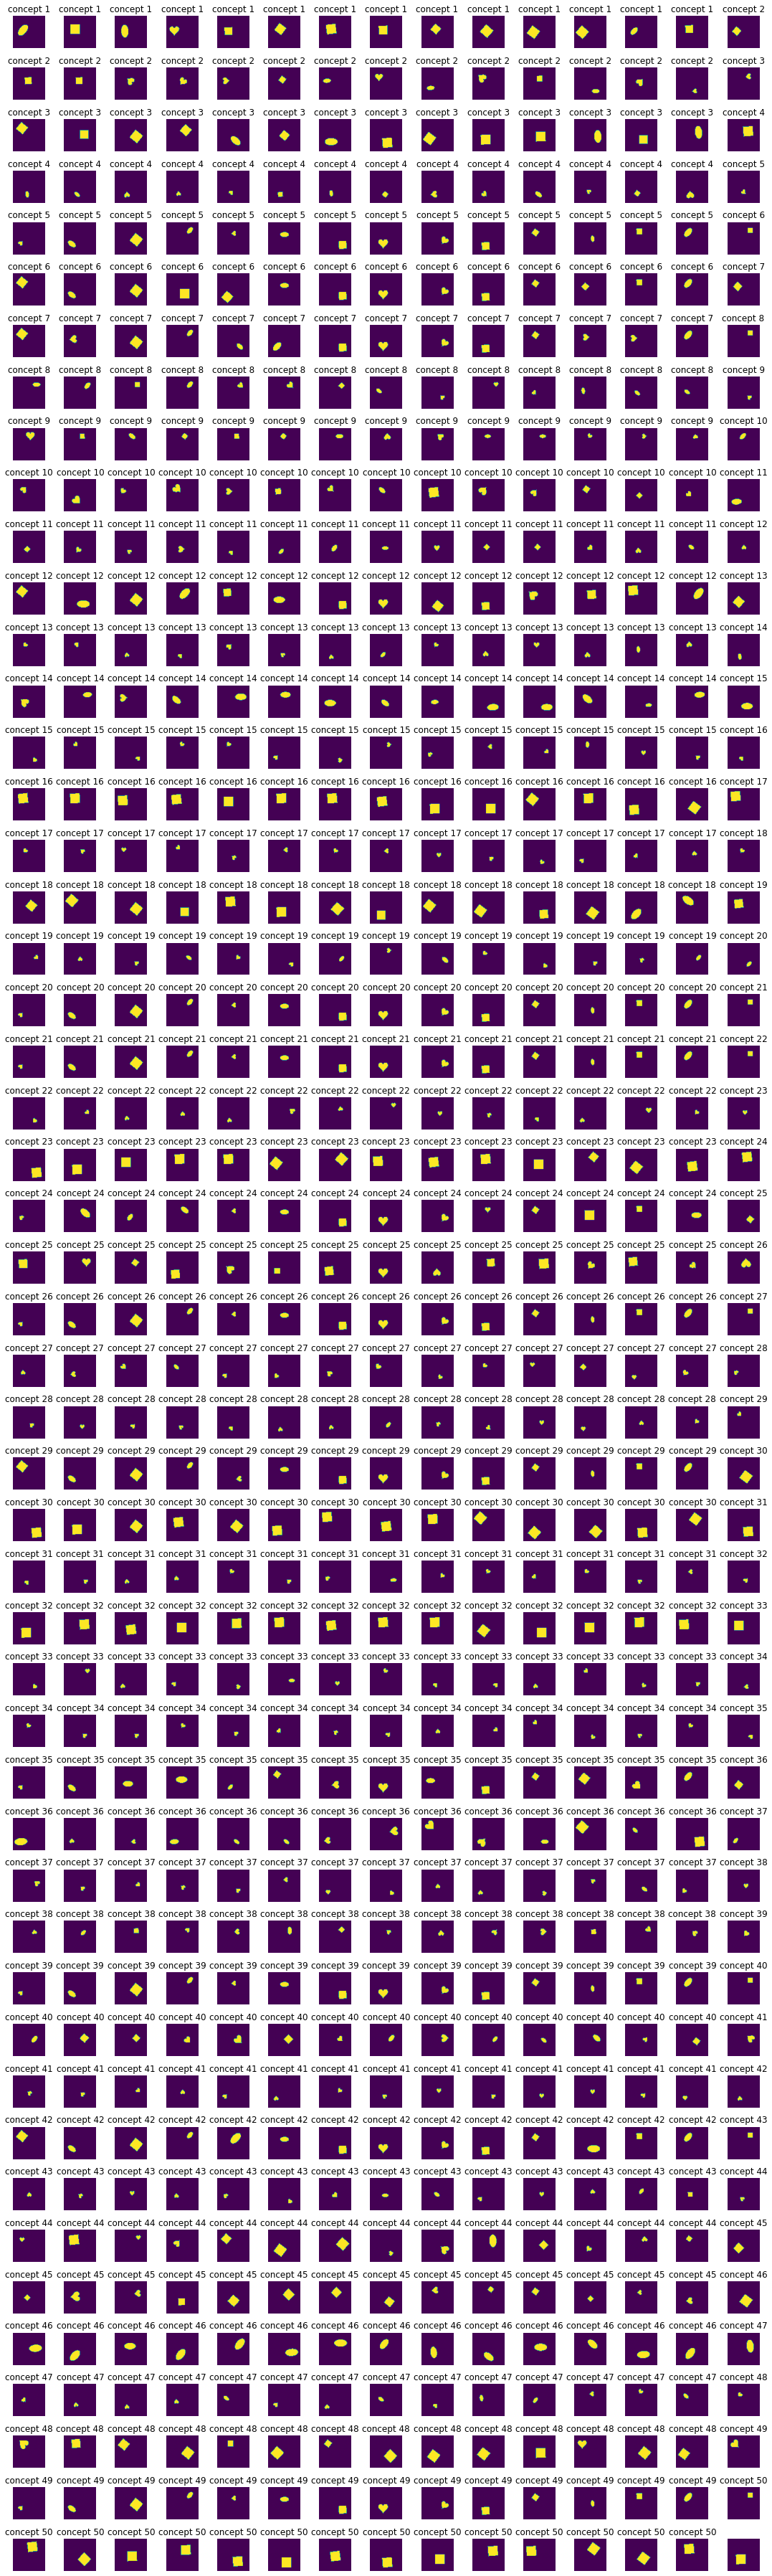

In [18]:
plt.figure(figsize=[15, n_concepts])
max_c = 15
max_r = n_concepts
k = 0
for q, c in enumerate(torch.topk(symbols.abs(), k=15, dim=0)[1].T):
    for j, cj in enumerate(c):
        plt.title(f'concept {q+1}')
        plt.subplot(max_r, max_c, k + 1)
        plt.imshow((x_subset[cj, 0] + 1))
        plt.axis('off')
        k = k + 1
    if k >= (max_c * max_r - 1): break
plt.tight_layout()
# plt.savefig(f'dsprites_concepts_c{n_concepts}.png')
plt.show()

# FOL formulas

In [19]:
# threshold = 0.

# # positive class
# target_class = 1
# start = time.time()
# class_explanation, class_explanations = logic.explain_class(model.cpu(),
#                                                             x_subset,
#                                                             symbols>threshold,
#                                                             y_subset % 2,
#                                                             target_class=target_class,
#                                                             simplify=True,
#                                                             topk_explanations=5)
# elapsed_time = time.time() - start
# print(class_explanations['layer_5-neuron_1'])
# class_explanation = class_explanations['layer_5-neuron_1']

# # %%

# # # model.eval()
# # # x_subset, y_subset = next(iter(valid_loader))
# pred_subset = model.cpu()(x_subset)
# # # print(class_explanation)
# y_formula = dl.logic.metrics.predictions(class_explanation, target_class,
#                                          model.log1.conceptizator.concepts>threshold,
#                                          y_subset % 2, metric=accuracy_score)
# y_pred = pred_subset[:, 0].detach().cpu().numpy()
# y_true = (y_subset.to(device) % 2 < 0.5).detach().cpu().numpy()
# print(y_formula.shape)
# print(y_pred.shape)
# print(y_true.shape)

# # %%

# # concept_consistency, formula_consistency,
# accuracy_model = accuracy_score(y_pred>0.5, y_true)
# accuracy = accuracy_score(y_formula, y_true)
# fidelity = dl.logic.metrics.fidelity(y_formula>0.5, y_pred>0.5)
# complexity = dl.logic.metrics.complexity(class_explanation)
# print(f'Accuracy: {accuracy}')
# print(f'Fidelity: {fidelity}')
# print(f'Complexity: {complexity}')